    Baisc imports

In [41]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio


import matplotlib.pyplot as plt
import IPython.display as ipd

from tqdm import tqdm

Transform all audio files from ogg to wav 

    - this step has been done through ffmpeg
    - command: for %i in (*.ogg) do ffmpeg -i "%i" "%~ni.wav" 

    Check the total number of files that we work with

In [42]:
import os

# total number of files
path = 'Inregistrari'
nr = 0
folders = ([name for name in os.listdir(path)
            if os.path.isdir(os.path.join(path, name))])  # all directories
for folder in folders:
    contents = os.listdir(os.path.join(path, folder))  # list of contents
    nr += len(contents)
    # print(folder,len(contents))
print(nr)


480


    Split the dataset in folders 

In [43]:
import os
import shutil
import random

random.seed(42)

train_set = 'Train_set'
test_set = 'Test_set'
valid_set = 'Valid_set'

train_ratio = 0.7
test_ratio = 0.2
valid_ratio = 0.1

# Function to remove existing files in directories
def clear_directory(directory):
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)
        if os.path.isfile(file_path):
            os.remove(file_path)

# Copy files in directories
def copy_files(file_list, destination_dir):
    for file_path in file_list:
        shutil.copy(file_path, destination_dir)

clear_directory(train_set)
clear_directory(test_set)
clear_directory(valid_set)

# List all files recursively
all_files = []
for root, dirs, files in os.walk(path):
    for file in files:
        all_files.append(os.path.join(root, file))

# Shuffle the file list
random.shuffle(all_files)

# Calculate the split indices
total_files = len(all_files)
train_split = int(total_files * train_ratio)
test_split = int(total_files * (train_ratio + test_ratio))

# Split the file list
train_files = all_files[:train_split]
test_files = all_files[train_split:test_split]
valid_files = all_files[test_split:]

# Copy files to respective directories
copy_files(train_files, train_set)
copy_files(test_files, test_set)
copy_files(valid_files, valid_set)


    Write in the csv and split the dataset as needed

In [44]:
import os
import random
import csv

random.seed(42)

root_dir = 'Inregistrari'
file_list = []

for dirpath, _, filenames in os.walk(root_dir):
    for filename in filenames:
        file_list.append(os.path.join(dirpath, filename))

random.shuffle(file_list)

train_ratio = 0.7
test_ratio = 0.2
valid_ratio = 0.1

total_files = len(file_list)
train_count = int(train_ratio * total_files)
test_count = int(test_ratio * total_files)
valid_count = total_files - train_count - test_count

train_set = file_list[:train_count]
test_set = file_list[train_count:train_count + test_count]
valid_set = file_list[train_count + test_count:]

speaker_id = {
    'Adi' : 0,
    'Anca': 1,
    'Bobo': 2,
    'Danila': 3,
    'Luci': 4,
    'Mada': 5,
    'Oana': 6,
    'Toni': 7
}

class_names = {
    'start': 0,
    'stop': 1,
    'home': 2,
    'pick_up': 3,
    'approach': 4,
    'free': 5
}


sets = {'train': 0, 'test': 1, 'valid': 2}

# Function to extract class from filename
def get_class(filename):
    # Split filename by underscores
    parts = filename.split('_')
    class_name = '_'.join(parts[:-1]).lower()
    return class_names.get(class_name, -1)

# Function to write dataset information to CSV
def write_to_csv(file_list, set_type):
    with open('dataset.csv', 'a', newline='') as csvfile:
        writer = csv.writer(csvfile)
        for file_path in file_list:
            filename = os.path.basename(file_path)
            folder_name = os.path.basename(os.path.dirname(file_path))
            file_with_folder = os.path.join(folder_name, filename)
            speaker_name = folder_name  # Extract speaker name from folder name
            speaker = speaker_id.get(speaker_name)  # Get speaker ID from dictionary
            if speaker is None:
                speaker = -1  # Assign -1 if speaker is not found
            class_label = get_class(filename)
            writer.writerow([file_with_folder, set_type, class_label, speaker])

# Clear existing dataset CSV file
with open('dataset.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['file_name', 'set', 'class', 'speaker_id'])

# Write information for train, test, and valid sets to CSV
write_to_csv(train_set, sets['train'])
write_to_csv(test_set, sets['test'])
write_to_csv(valid_set, sets['valid'])


    Check waveform, sample rate and display audio
 

Inregistrari\Bobo\free_4.wav
(16000, array([ -3,   0,  -3, ..., 245, 268, 299], dtype=int16))


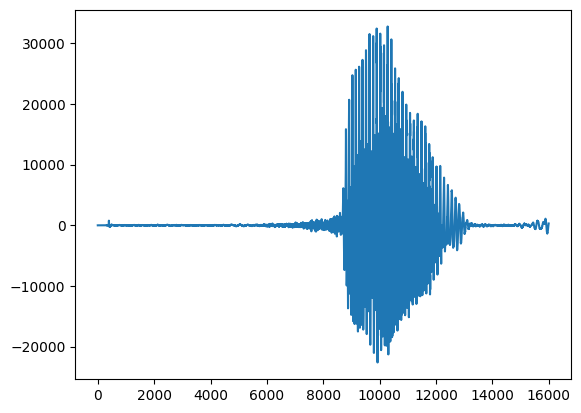

16000
1.0 seconds


In [45]:
from scipy.io.wavfile import read
import matplotlib.pyplot as plt
from IPython.display import Audio
import librosa 


print(test_files[8])
input_data = read(test_files[8])
audio = input_data[1]
print(input_data)

plt.plot(audio)
plt.show()

y, sr = librosa.load(test_files[6], sr=None)
Audio(data=y, rate=sr)
print(sr)
duration = librosa.get_duration(y=y, sr=sr)

print(duration, "seconds")

    Resample all audios in a folder and make them the same length

In [46]:
import os
import soundfile as sf
import librosa
import numpy as np

path = 'Inregistrari/Toni'
new_sample_rate = 16000

# Get a list of all files in the specified path
files = [os.path.join(path, name) for name in os.listdir(path) if os.path.isfile(os.path.join(path, name))]

for file in files:
    # Load the audio file
    y, sr = librosa.load(file, sr=None)
    
    # Resample the audio to 16000 Hz
    y_resampled = librosa.resample(y, orig_sr=sr, target_sr=16000)
    
    # Trim the audio to exactly one second if its duration is greater than 1 second
    if len(y_resampled) > new_sample_rate:
        start_index = len(y_resampled) - new_sample_rate
        y_one_second = y_resampled[start_index:]
    else:
        # Pad the audio with zeros if its duration is less than 1 second
        num_zeros = new_sample_rate - len(y_resampled)
        y_one_second = np.concatenate((y_resampled, np.zeros(num_zeros)))

    y_normalized = y_one_second / np.max(np.abs(y_one_second))

    # Save the resampled and trimmed audio (overwrite the existing files)
    sf.write(file, y_normalized, new_sample_rate)


    Resample and trim for specific files in 'Copie' folder

     No need to run this

In [14]:
# import librosa
# import soundfile as sf
# import matplotlib.pyplot as plt

# file = 'Inregistrari/Copie/approach_4.wav'
# new_sample_rate = 16000

# # Load the audio file
# y, sr = librosa.load(file, sr=None)

# # Resample the audio to 16000 Hz
# y_resampled = librosa.resample(y=y, orig_sr=sr, target_sr=new_sample_rate)

# # Save the resampled audio to a new file using soundfile
# output_file_resampled = 'approach_4_resampled.wav'
# sf.write(output_file_resampled, y_resampled, 16000)

# # Trim the resampled audio to keep only the last second
# # Calculate the starting index for the last second
# start_index = len(y_resampled) - new_sample_rate

# # Extract the last second of the resampled audio
# y_last_second = y_resampled[start_index:]

# # Save the trimmed audio to the same file
# output_file_trimmed = 'approach_4_resampled.wav'
# sf.write(output_file_trimmed, y_last_second, 16000)

# # Display the waveform of the trimmed audio
# plt.plot(y_last_second)
# plt.show()

    Check that all files in a specific folder have the same sr and duration

In [47]:
import os
import librosa

path = 'Inregistrari/Luci'

# Get a list of all files in the folder
files = [os.path.join(path, name) for name in os.listdir(path) if os.path.isfile(os.path.join(path, name))]

# Initialize variables to store the duration and sample rate of the first file
first_duration = None
first_sr = None

# Iterate through each file
for file in files:
    # Load the audio file and get its duration and sample rate
    y, sr = librosa.load(file, sr=None)
    duration = librosa.get_duration(y=y, sr=sr)
    
    # If this is the first file, store its duration and sample rate
    if first_duration is None:
        first_duration = duration
        first_sr = sr
    else:
        # Compare the duration and sample rate of this file with the first file
        if duration != first_duration or sr != first_sr:
            print(f"File {file} has different duration or sample rate.")
            print(f"Expected duration: {first_duration}, Sample rate: {first_sr}")
            print(f"Actual duration: {duration}, Sample rate: {sr}")


    Encoding each word from the three dictionaries with its index

In [48]:
import torch

speaker_id = {
    'Adi' : 0,
    'Anca': 1,
    'Bobo': 2,
    'Danila': 3,
    'Luci': 4,
    'Mada': 5,
    'Oana': 6,
    'Toni': 7
}

class_names = {
    'start': 0,
    'stop': 1,
    'home': 2,
    'pick_up': 3,
    'approach': 4,
    'free': 5
}

sets = {'train': 0, 'test': 1, 'valid': 2}


def label_to_index(labels_dict, word):
    # Return the index corresponding to the word in the labels dictionary
    return torch.tensor(labels_dict[word])


def index_to_label(labels_dict, index):
    # Return the word corresponding to the index in the labels dictionary
    for word, idx in labels_dict.items():
        if idx == index:
            return word
    return None  # Return None if index is not found


# Example usage:
word_start = "approach"
index = label_to_index(class_names, word_start)
word_recovered = index_to_label(class_names, index)

print(word_start, "-->", index.item(), "-->", word_recovered)

word_start = "Bobo"
index = label_to_index(speaker_id, word_start)
word_recovered = index_to_label(speaker_id, index)

print(word_start, "-->", index.item(), "-->", word_recovered)

word_start = "test"
index = label_to_index(sets, word_start)
word_recovered = index_to_label(sets, index)

print(word_start, "-->", index.item(), "-->", word_recovered)



approach --> 4 --> approach
Bobo --> 2 --> Bobo
test --> 1 --> test


In [170]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


    Load the data in th DataLoader

In [171]:
import pandas as pd
from torch.utils.data import Dataset
import os
import torchaudio

class My_Dataset(Dataset):

    def __init__(self, csv_file, root_dir, set_number):
        """
        Arguments:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the audio files.
            set_number (int): Set number to filter the samples.
        """
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.set_number = set_number
        self.filtered_indices = self.filter()

    def __len__(self):
        return len(self.filtered_indices)

    def filter(self):
        filtered_indices = []
        for idx in range(len(self.data)):
            set_value = int(self.data.iloc[idx, 1])
            if set_value == self.set_number:
                filtered_indices.append(idx)
        return filtered_indices

    def __getitem__(self, idx):
        idx = self.filtered_indices[idx]
        file = os.path.join(self.root_dir, self.data.iloc[idx, 0])
        class_label = int(self.data.iloc[idx, 2])
        waveform, _ = torchaudio.load(file)
        return waveform, class_label

csv_file = 'dataset.csv'
root_dir = 'Inregistrari'
train_dataset = My_Dataset(csv_file, root_dir, 0)
test_dataset = My_Dataset(csv_file, root_dir, 1)
valid_dataset = My_Dataset(csv_file, root_dir, 2)
print(train_dataset[0])
print(test_dataset[0])
print(valid_dataset[0])


(tensor([[-0.0282, -0.0244, -0.0236,  ...,  0.0104,  0.0114,  0.0126]]), 3)
(tensor([[ 9.1553e-05, -2.7466e-04, -9.1553e-04,  ..., -3.9673e-04,
         -4.8828e-04, -4.5776e-04]]), 2)
(tensor([[-0.0032, -0.0017, -0.0019,  ...,  0.0024,  0.0081,  0.0065]]), 3)


In [172]:
batch_size = 64


if device == "cuda":
    num_workers = 2
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False


train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

In [173]:
classes = ['start', 'stop', 'home', 'pick_up', 'approach', 'free']



    Define the model
    

In [197]:
import torch.nn as nn
import torch.nn.functional as F

class M4(nn.Module):
    def __init__(self, n_input=1, n_output=6, stride=16, n_channel=32):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        # self.fc1 = nn.Linear(2 * n_channel, n_output)
        self.fc1 = nn.LazyLinear(n_output)
    

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        x = x.squeeze(1)
        return F.log_softmax(x, dim=1)


model = M4(n_input=1, n_output=len(classes))
model.to(device)
model(torch.randn([64, 1, 16000]))
print(model)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


n = count_parameters(model)
print("Number of parameters: %s" % n)

M4(
  (conv1): Conv1d(1, 32, kernel_size=(80,), stride=(16,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=6, bias=True)
)
Number

c:\Users\Antonia\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [198]:
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)  # reduce the learning after 20 epochs by a factor of 10

    TRAIN AND TEST

In [199]:
train_l = []
train_a = []  # Initialize list to store average accuracy for each epoch

def train(model, epoch, log_interval):
    model.train()
    total_loss = 0
    total_correct = 0  # Initialize total number of correct predictions
    total = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device)
        target = target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output.squeeze(), target)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * data.size(0)
        total += data.size(0)

        # Calculate number of correct predictions
        pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max log-probability
        correct = pred.eq(target.view_as(pred)).sum().item()
        total_correct += correct

        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

    avg_loss = total_loss / total
    train_l.append(avg_loss)

    avg_accuracy = total_correct / total  # Calculate average accuracy for the epoch
    train_a.append(avg_accuracy)  # Append average accuracy to the list

    print(f"\nTrain Epoch: {epoch}\tAverage Loss: {avg_loss:.6f}\tAverage Accuracy: {avg_accuracy:.2f}\n")

In [200]:
def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()


def get_likely_index(tensor):
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)

true_labels = []
predictions = []
test_l = []
test_a = []
#clear lists
true_labels.clear()
predictions.clear()
test_l.clear()
test_a.clear()

def test(model, epoch):
    model.eval()
    correct = 0
    total_loss = 0  # Initialize total loss for the epoch
    total = 0  # Total number of samples processed

    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device)
            target = target.to(device)

            output = model(data)
            pred = get_likely_index(output)
            correct += number_of_correct(pred, target)

            _, predicted = torch.max(output, 1)
            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(target.cpu().numpy())

            # Calculate loss for the current batch and accumulate it
            test_loss = F.nll_loss(output.squeeze(), target).item()
            total_loss += test_loss * data.size(0)  # Multiply by batch size to get total loss for the batch
            total += data.size(0)  # Accumulate the total number of samples

        # Calculate average loss and accuracy for the epoch
        avg_loss = total_loss / total
        accuracy = correct / total

        # Append the calculated metrics to their respective lists
        test_l.append(avg_loss)
        test_a.append(accuracy)

        print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{total} ({100. * accuracy:.0f}%)\n")

In [201]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
from tqdm import tqdm

log_interval = 20
n_epoch = 200

pbar_update = 1 / (len(train_loader) + len(test_loader))
losses = []

# The transform needs to live on the same device as the model and the data.
# transform = transform.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval)
        test(model, epoch)
        torch.save(model.state_dict(), 'best_command.pt')
        scheduler.step()


  0%|          | 0/200 [00:00<?, ?it/s]

Train Epoch: 1 [0/336 (0%)]	Loss: 1.957748

Train Epoch: 1	Average Loss: 1.731143	Average Accuracy: 0.27


Test Epoch: 1	Accuracy: 12/96 (12%)

Train Epoch: 2 [0/336 (0%)]	Loss: 1.400676

Train Epoch: 2	Average Loss: 1.343518	Average Accuracy: 0.61


Test Epoch: 2	Accuracy: 23/96 (24%)

Train Epoch: 3 [0/336 (0%)]	Loss: 1.163143

Train Epoch: 3	Average Loss: 1.166737	Average Accuracy: 0.72


Test Epoch: 3	Accuracy: 25/96 (26%)

Train Epoch: 4 [0/336 (0%)]	Loss: 1.043238

Train Epoch: 4	Average Loss: 1.043081	Average Accuracy: 0.75


Test Epoch: 4	Accuracy: 47/96 (49%)

Train Epoch: 5 [0/336 (0%)]	Loss: 1.008293

Train Epoch: 5	Average Loss: 0.914278	Average Accuracy: 0.84


Test Epoch: 5	Accuracy: 64/96 (67%)

Train Epoch: 6 [0/336 (0%)]	Loss: 0.908884

Train Epoch: 6	Average Loss: 0.814850	Average Accuracy: 0.88


Test Epoch: 6	Accuracy: 68/96 (71%)

Train Epoch: 7 [0/336 (0%)]	Loss: 0.801498

Train Epoch: 7	Average Loss: 0.712627	Average Accuracy: 0.91


Test Epoch: 7	Accuracy: 68/96

  0%|          | 0/200 [01:18<?, ?it/s]


Train Epoch: 200	Average Loss: 0.090162	Average Accuracy: 1.00


Test Epoch: 200	Accuracy: 85/96 (89%)



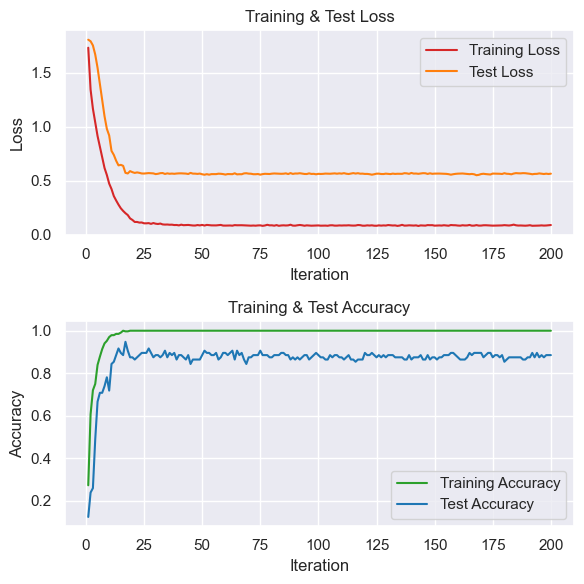

In [202]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

# Assuming the number of epochs is the length of the longest list
num_epochs = 200
epochs = range(1, num_epochs + 1)

# Create a figure with 2 subplots, vertically aligned, with a smaller size
fig, axs = plt.subplots(2, 1, figsize=(6, 6))

# Plot training loss and test loss in the same subplot
axs[0].plot(epochs[:len(train_l)], train_l, label='Training Loss', color='tab:red')
axs[0].plot(epochs[:len(test_l)], test_l, label='Test Loss', color='tab:orange')
axs[0].set_title('Training & Test Loss')
axs[0].set_xlabel('Iteration')
axs[0].set_ylabel('Loss')
axs[0].legend()

# Plot training accuracy and test accuracy in the same subplot
axs[1].plot(epochs[:len(train_a)], train_a, label='Training Accuracy', color='tab:green')
axs[1].plot(epochs[:len(test_a)], test_a, label='Test Accuracy', color='tab:blue')
axs[1].set_title('Training & Test Accuracy')
axs[1].set_xlabel('Iteration')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

# Adjust layout to prevent overlap
plt.tight_layout()

plt.show()

In [203]:
from sklearn.metrics import classification_report

# Assuming the testing loop code here

# After the testing loop
report = classification_report(true_labels, predictions, target_names=['start', 'stop', 'home', 'pick_up', 'approach', 'free'])  # Adjust target_names based on your dataset
print(report)

              precision    recall  f1-score   support

       start       0.78      0.96      0.86      2400
        stop       0.92      0.70      0.80      4400
        home       0.88      0.90      0.89      3000
     pick_up       0.96      0.84      0.89      3800
    approach       0.72      0.97      0.83      2800
        free       0.96      0.92      0.94      2800

    accuracy                           0.86     19200
   macro avg       0.87      0.88      0.87     19200
weighted avg       0.88      0.86      0.86     19200



In [204]:
from sklearn.metrics import confusion_matrix

confision_matrix = confusion_matrix(true_labels, predictions)
print(confision_matrix)

[[2296   18    1   77    0    8]
 [ 224 3102  180   45  820   29]
 [ 213   26 2711   16    7   27]
 [ 179  195    0 3189  224   13]
 [  24   40    0    4 2705   27]
 [  20    0  197    2    1 2580]]


In [205]:
def predict(tensor):
    # Use the model to predict the label of the waveform
    tensor = tensor.to(device)
    tensor = model(tensor.unsqueeze(0))
    tensor = get_likely_index(tensor)
    return tensor

nr = 0
for i in range(len(valid_dataset)):
    waveform, utterance = valid_dataset[i]
    if utterance != predict(waveform).item():
        nr += 1
        print(f"Expected: {utterance}. Predicted: {predict(waveform).item()}.")

print(nr)

Expected: 3. Predicted: 0.
Expected: 1. Predicted: 3.
Expected: 4. Predicted: 1.
Expected: 0. Predicted: 1.
Expected: 1. Predicted: 3.
Expected: 5. Predicted: 3.
Expected: 1. Predicted: 3.
7


In [46]:
# path = 'recordings'

# def predict(tensor):
#     # Use the model to predict the label of the waveform
#     tensor = tensor.to(device)
#     tensor = model(tensor.unsqueeze(0))
#     tensor = get_likely_index(tensor)
#     return tensor

# # go through all files in the folder put them in a list
# for file in os.listdir(path):
#     if file.endswith('.wav'):
#         file_path = os.path.join(path, file)
#         waveform, _ = torchaudio.load(file_path)
#         print(f"Predicted: {predict(waveform).item()}. File: {file_path}")
#         # print(f"Expected: {utterance}. Predicted: {predict(waveform).item()}.")

# # classes = ['start', 'stop', 'home', 'pick_up', 'approach', 'free']
# class_names = {
#     'start': 0,
#     'stop': 1,
#     'home': 2,
#     'pick_up': 3,
#     'approach': 4,
#     'free': 5
# }


    SPEAKER IDENTIFICATION

In [206]:
import pandas as pd
from torch.utils.data import Dataset
import os
import torchaudio

class My_Dataset(Dataset):

    def __init__(self, csv_file, root_dir, set_number):
        """
        Arguments:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the audio files.
            set_number (int): Set number to filter the samples.
        """
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.set_number = set_number
        self.filtered_indices = self.filter()
        ## self.output = mfcc sau waveform 
        ## if slef.out = mfcc sau wave in get item 

    def __len__(self):
        return len(self.filtered_indices)

    def filter(self):
        filtered_indices = []
        for idx in range(len(self.data)):
            set_value = int(self.data.iloc[idx, 1])
            if set_value == self.set_number:
                filtered_indices.append(idx)
        return filtered_indices

    def __getitem__(self, idx):
        idx = self.filtered_indices[idx]
        file = os.path.join(self.root_dir, self.data.iloc[idx, 0])
        speaker_id = int(self.data.iloc[idx, 3])
        waveform, _ = torchaudio.load(file)
        return waveform, speaker_id

csv_file = 'dataset.csv'
root_dir = 'Inregistrari'
train_dataset = My_Dataset(csv_file, root_dir, 0)
test_dataset = My_Dataset(csv_file, root_dir, 1)
valid_dataset = My_Dataset(csv_file, root_dir, 2)
print(train_dataset[0])
print(test_dataset[0])
print(valid_dataset[0])


(tensor([[-0.0282, -0.0244, -0.0236,  ...,  0.0104,  0.0114,  0.0126]]), 7)
(tensor([[ 9.1553e-05, -2.7466e-04, -9.1553e-04,  ..., -3.9673e-04,
         -4.8828e-04, -4.5776e-04]]), 4)
(tensor([[-0.0032, -0.0017, -0.0019,  ...,  0.0024,  0.0081,  0.0065]]), 6)


In [207]:
batch_size = 64

if device == "cuda":
    num_workers = 2
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False


train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    # collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    # collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

In [208]:
classes_pers = ['Adi', 'Anca', 'Bobo', 'Danila', 'Luci', 'Mada', 'Oana', 'Toni']

In [209]:
class M5(nn.Module):
    def __init__(self, n_input=1, n_output=8, stride=16, n_channel=32):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        # self.fc1 = nn.Linear(2 * n_channel, n_output)
        self.fc1 = nn.LazyLinear(n_output)
    

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        x = x.squeeze(1)
        return F.log_softmax(x, dim=1)


model = M5(n_input=1, n_output=len(classes_pers))
model.to(device)
model(torch.randn([64, 1, 16000]))
print(model)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


n = count_parameters(model)
print("Number of parameters: %s" % n)

M5(
  (conv1): Conv1d(1, 32, kernel_size=(80,), stride=(16,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=8, bias=True)
)
Number

c:\Users\Antonia\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [210]:
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)  # reduce the learning after 20 epochs by a factor of 10

In [211]:
train_l_speaker = []
train_a_speaker = []  # Initialize list to store average accuracy for each epoch

def train(model, epoch, log_interval):
    model.train()
    total_loss = 0
    total_correct = 0  # Initialize total number of correct predictions
    total = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device)
        target = target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output.squeeze(), target)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * data.size(0)
        total += data.size(0)

        # Calculate number of correct predictions
        pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max log-probability
        correct = pred.eq(target.view_as(pred)).sum().item()
        total_correct += correct

        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

    avg_loss = total_loss / total
    train_l_speaker.append(avg_loss)

    avg_accuracy = total_correct / total  # Calculate average accuracy for the epoch
    train_a_speaker.append(avg_accuracy)  # Append average accuracy to the list

    print(f"\nTrain Epoch: {epoch}\tAverage Loss: {avg_loss:.6f}\tAverage Accuracy: {avg_accuracy:.2f}\n")

In [212]:
def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()


def get_likely_index(tensor):
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)

true_labels_speaker = []
predictions_speaker = []
test_l_speaker = []
test_a_speaker = []


def test(model, epoch):
    model.eval()
    correct = 0
    total_loss = 0  # Initialize total loss for the epoch
    total = 0  # Total number of samples processed

    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device)
            target = target.to(device)

            output = model(data)
            pred = get_likely_index(output)
            correct += number_of_correct(pred, target)

            _, predicted = torch.max(output, 1)
            predictions_speaker.extend(predicted.cpu().numpy())
            true_labels_speaker.extend(target.cpu().numpy())

            # Calculate loss for the current batch and accumulate it
            test_loss = F.nll_loss(output.squeeze(), target).item()
            total_loss += test_loss * data.size(0)  # Multiply by batch size to get total loss for the batch
            total += data.size(0)  # Accumulate the total number of samples

        # Calculate average loss and accuracy for the epoch
        avg_loss = total_loss / total
        accuracy = correct / total

        # Append the calculated metrics to their respective lists
        test_l_speaker.append(avg_loss)
        test_a_speaker.append(accuracy)

        print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{total} ({100. * accuracy:.0f}%)\n")

In [213]:
log_interval = 20
n_epoch = 150

pbar_update = 1 / (len(train_loader) + len(test_loader))
losses = []


# The transform needs to live on the same device as the model and the data.
# transform = transform.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval)
        
        test(model, epoch)
        torch.save(model.state_dict(), 'best_speaker.pt')
        scheduler.step()


  0%|          | 0/150 [00:00<?, ?it/s]

Train Epoch: 1 [0/336 (0%)]	Loss: 2.221062

Train Epoch: 1	Average Loss: 2.044579	Average Accuracy: 0.25


Test Epoch: 1	Accuracy: 9/96 (9%)

Train Epoch: 2 [0/336 (0%)]	Loss: 1.757538

Train Epoch: 2	Average Loss: 1.688496	Average Accuracy: 0.55


Test Epoch: 2	Accuracy: 9/96 (9%)

Train Epoch: 3 [0/336 (0%)]	Loss: 1.514546

Train Epoch: 3	Average Loss: 1.440244	Average Accuracy: 0.78


Test Epoch: 3	Accuracy: 9/96 (9%)

Train Epoch: 4 [0/336 (0%)]	Loss: 1.340515

Train Epoch: 4	Average Loss: 1.259900	Average Accuracy: 0.85


Test Epoch: 4	Accuracy: 9/96 (9%)

Train Epoch: 5 [0/336 (0%)]	Loss: 1.158370

Train Epoch: 5	Average Loss: 1.071339	Average Accuracy: 0.90


Test Epoch: 5	Accuracy: 17/96 (18%)

Train Epoch: 6 [0/336 (0%)]	Loss: 0.915198

Train Epoch: 6	Average Loss: 0.924470	Average Accuracy: 0.94


Test Epoch: 6	Accuracy: 49/96 (51%)

Train Epoch: 7 [0/336 (0%)]	Loss: 0.839443

Train Epoch: 7	Average Loss: 0.797770	Average Accuracy: 0.96


Test Epoch: 7	Accuracy: 62/96 (65%)



  0%|          | 0/150 [01:07<?, ?it/s]


Train Epoch: 150	Average Loss: 0.070427	Average Accuracy: 1.00


Test Epoch: 150	Accuracy: 92/96 (96%)



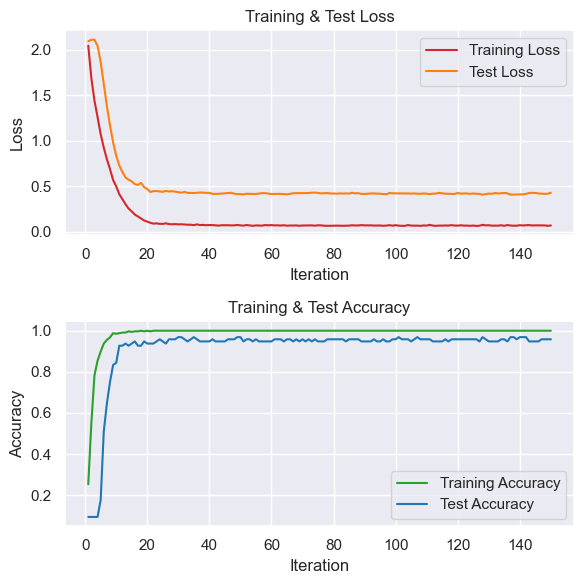

In [214]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

# Assuming the number of epochs is the length of the longest list
num_epochs = 150
epochs = range(1, num_epochs + 1)

# Create a figure with 2 subplots, vertically aligned, with a smaller size
fig, axs = plt.subplots(2, 1, figsize=(6, 6))

# Plot training loss and test loss in the same subplot
axs[0].plot(epochs[:len(train_l_speaker)], train_l_speaker, label='Training Loss', color='tab:red')
axs[0].plot(epochs[:len(test_l_speaker)], test_l_speaker, label='Test Loss', color='tab:orange')
axs[0].set_title('Training & Test Loss')
axs[0].set_xlabel('Iteration')
axs[0].set_ylabel('Loss')
axs[0].legend()

# Plot training accuracy and test accuracy in the same subplot
axs[1].plot(epochs[:len(train_a_speaker)], train_a_speaker, label='Training Accuracy', color='tab:green')
axs[1].plot(epochs[:len(test_a_speaker)], test_a_speaker, label='Test Accuracy', color='tab:blue')
axs[1].set_title('Training & Test Accuracy')
axs[1].set_xlabel('Iteration')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

# Adjust layout to prevent overlap
plt.tight_layout()

plt.show()

In [215]:
from sklearn.metrics import classification_report
report = classification_report(true_labels_speaker, predictions_speaker, target_names=['Adi', 'Anca', 'Bobo', 'Danila', 'Luci', 'Mada', 'Oana', 'Toni'])  # Adjust target_names based on your dataset
print(report)

              precision    recall  f1-score   support

         Adi       0.63      1.00      0.78      1350
        Anca       1.00      0.78      0.87      1500
        Bobo       1.00      0.88      0.94      1800
      Danila       1.00      0.93      0.96      2250
        Luci       0.99      0.95      0.97      1650
        Mada       0.97      0.96      0.96      1950
        Oana       0.99      0.87      0.93      1800
        Toni       0.87      0.96      0.91      2100

    accuracy                           0.92     14400
   macro avg       0.93      0.92      0.91     14400
weighted avg       0.94      0.92      0.92     14400



In [216]:
from sklearn.metrics import confusion_matrix

confision_matrix = confusion_matrix(true_labels_speaker, predictions_speaker)
print(confision_matrix)

[[1350    0    0    0    0    0    0    0]
 [ 198 1163    6    0    1    2   15  115]
 [ 205    0 1586    6    0    0    3    0]
 [  73    0    0 2095    1   44    0   37]
 [  76    0    0    0 1569    2    3    0]
 [  76    0    0    0    1 1868    0    5]
 [  71    1    0    0    0    0 1572  156]
 [  82    0    0    0    5    6    0 2007]]


In [217]:
def predict(tensor):
    # Use the model to predict the label of the waveform
    tensor = tensor.to(device)
    tensor = model(tensor.unsqueeze(0))
    tensor = get_likely_index(tensor)
    return tensor

nr = 0
for i in range(len(valid_dataset)):
    waveform, utterance = valid_dataset[i]
    if utterance != predict(waveform).item():
        nr += 1
        print(f"Expected: {utterance}. Predicted: {predict(waveform).item()}.")

print(nr)

0
